<a href="https://colab.research.google.com/github/meanwo/gas_amount_prediction/blob/main/XGBoost_withour_weather.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
import datetime
warnings.filterwarnings('ignore')
plt.rc('font', family='Malgun Gothic') 


In [3]:
# datetime을 index로 옮겨주는 함수
def datetime_revise(df):
    # python datetime에서는 시간을 0~23시까지밖에 인식을 못하기 때문에 1을 빼준다.
    df.index = pd.to_datetime(df['datetime']) + pd.to_timedelta(df['hour'], unit='hours')
    df.drop(['year', 'month', 'day', 'weekday', 'hour', 'datetime'], axis=1, inplace=True)
    return df

In [4]:
# 시계열 분석을 위해 target값만을 뽑음
def make_df(df, colname):
    df = df.query(f'supplys == "{colname}"')
    return df['target']

In [5]:
def make_df_with_tmp(df, colname):
    df = df.query(f'supplys == "{colname}"')
    return df

In [6]:
# upsamplingm downsampling해줄 수 있도록 하는 함수
def set_freq(df, freq='m'):
    tmp =  pd.DataFrame(df.resample(freq).sum())
    return tmp[tmp['target'] != 0.0]

In [7]:
total = pd.read_csv('no_outlier_data.csv')
# total = pd.read_csv('data/no_outlier_data.csv')

total = datetime_revise(total)
total.head()
total.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 367920 entries, 2013-01-01 01:00:00 to 2019-01-01 00:00:00
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   supplys    367920 non-null  object 
 1   avg_temp   367920 non-null  float64
 2   mini_temp  367920 non-null  float64
 3   max_temp   367920 non-null  float64
 4   target     367920 non-null  float64
dtypes: float64(4), object(1)
memory usage: 16.8+ MB


In [8]:
# 공급사 이름
supply_name_list = [n for n in total['supplys'].unique().tolist()]
supply_name_list

['A', 'B', 'C', 'D', 'E', 'G', 'H']

## 시계열 데이터 탐색

In [9]:
# acf, pacf graph
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts


In [10]:
# 한 번에 분석하기 용이하도록 각 공급사별로 일별 공급 데이터만 담긴 series를 따로 저장
colname = total['supplys'].unique().tolist()
colname

['A', 'B', 'C', 'D', 'E', 'G', 'H']

In [11]:
# 시간대별 분석
hour_time_series = [set_freq(make_df(total, col), freq='h') for col in colname]
A_df = hour_time_series[0]

In [12]:
# time_index 저장하자
time_index = A_df.index

## 변수 탐색

In [13]:
A_df_var = A_df.reset_index().copy()
A_df_var

,index,target
0,2013-01-01 01:00:00,2497.129
1,2013-01-01 02:00:00,2363.265
2,2013-01-01 03:00:00,2258.505
3,2013-01-01 04:00:00,2243.969
4,2013-01-01 05:00:00,2344.105
...,...,...
52555,2018-12-31 20:00:00,3040.868
52556,2018-12-31 21:00:00,2973.577
52557,2018-12-31 22:00:00,2840.272
52558,2018-12-31 23:00:00,2692.385


In [14]:
# 날짜 변수 추가
A_df_var['hour'] = A_df_var['index'].dt.hour
A_df_var['weekday'] = A_df_var['index'].dt.weekday
A_df_var['month'] = A_df_var['index'].dt.month
A_df_var['week'] =  A_df_var['index'].dt.weekofyear

In [18]:
A_df_var

,index,target,hour,weekday,month,week
0,2013-01-01 01:00:00,2497.129,1,1,1,1
1,2013-01-01 02:00:00,2363.265,2,1,1,1
2,2013-01-01 03:00:00,2258.505,3,1,1,1
3,2013-01-01 04:00:00,2243.969,4,1,1,1
4,2013-01-01 05:00:00,2344.105,5,1,1,1
...,...,...,...,...,...,...
52555,2018-12-31 20:00:00,3040.868,20,0,12,1
52556,2018-12-31 21:00:00,2973.577,21,0,12,1
52557,2018-12-31 22:00:00,2840.272,22,0,12,1
52558,2018-12-31 23:00:00,2692.385,23,0,12,1


In [22]:
# 요일별, 시간별 평균
power_week_hour_mean = pd.pivot_table(A_df_var, values = 'target', index = ['hour', 'weekday'], aggfunc = np.mean).reset_index()
tqdm.pandas()
A_df_var['week_hour_mean'] = A_df_var.progress_apply(lambda x : power_week_hour_mean.loc[(power_week_hour_mean.hour == x['hour']) & (power_week_hour_mean.weekday == x['weekday']) ,'target'].values[0], axis = 1)

power_week_hour_mean.tail()


100%|██████████| 52560/52560 [00:38<00:00, 1360.18it/s]


,hour,weekday,target
163,23,2,1244.001333
164,23,3,1248.213652
165,23,4,1201.269010
166,23,5,1078.029294
167,23,6,1099.235987


In [26]:
power_week_hour_mean.head()

,hour,weekday,target
0,0,0,1025.271259
1,0,1,1133.169160
2,0,2,1153.783674
3,0,3,1151.081013
4,0,4,1158.889067


In [31]:
power_week_hour_mean[8:16]

,hour,weekday,target
8,1,1,985.318879
9,1,2,999.873856
10,1,3,998.138629
11,1,4,1011.740003
12,1,5,1004.955537
13,1,6,917.548620
14,2,0,741.612567
15,2,1,820.722869


In [27]:
# 시간별 평균 = 
power_hour_mean =  pd.pivot_table(A_df_var, values = 'target', index = ['hour'], aggfunc = np.mean).reset_index()
tqdm.pandas()
A_df_var['hour_mean'] = A_df_var.progress_apply(lambda x : power_hour_mean.loc[(power_hour_mean.hour == x['hour'])  ,'target'].values[0], axis = 1)
power_hour_mean.head()

100%|██████████| 52560/52560 [00:21<00:00, 2441.74it/s]


,hour,target
0,0,1109.858680
1,1,972.691102
2,2,814.406044
3,3,732.084785
4,4,748.616821


In [23]:
def to_mean_std(df):
    # 요일별, 시간별 평균
    power_week_hour_mean = pd.pivot_table(df, values = 'target', index = ['hour', 'weekday'], aggfunc = np.mean).reset_index()
    df['week_hour_mean'] = df.progress_apply(lambda x : power_week_hour_mean.loc[(power_week_hour_mean.hour == x['hour']) & (power_week_hour_mean.weekday == x['weekday']) ,'target'].values[0], axis = 1)    
    
    power_hour_mean =  pd.pivot_table(df, values = 'target', index = ['hour'], aggfunc = np.mean).reset_index()
    df['hour_mean'] = df.progress_apply(lambda x : power_hour_mean.loc[(power_hour_mean.hour == x['hour'])  ,'target'].values[0], axis = 1)
    
    power_week_mean =  pd.pivot_table(df, values = 'target', index = ['weekday'], aggfunc = np.mean).reset_index()
    df['week_mean'] = df.progress_apply(lambda x : power_week_mean.loc[(power_week_mean.weekday == x['weekday'])  ,'target'].values[0], axis = 1)
    
    power_week_hour_std = pd.pivot_table(df, values = 'target', index = ['hour', 'weekday'], aggfunc = np.std).reset_index()
    df['week_hour_std'] = df.progress_apply(lambda x : power_week_hour_std.loc[(power_week_hour_std.hour == x['hour']) & (power_week_hour_std.weekday == x['weekday']) ,'target'].values[0], axis = 1)
    
    power_hour_std = pd.pivot_table(df, values = 'target', index = ['hour'], aggfunc = np.std).reset_index()
    df['hour_std'] = df.progress_apply(lambda x : power_hour_std.loc[(power_hour_std.hour == x['hour'])  ,'target'].values[0], axis = 1)
    
    power_week_std = pd.pivot_table(df, values = 'target', index = ['weekday'], aggfunc = np.std).reset_index()
    df['week_std'] = df.progress_apply(lambda x :  power_week_std.loc[( power_week_std.weekday == x['weekday'])  ,'target'].values[0], axis = 1)
    
    return [power_week_hour_mean, power_hour_mean, power_week_mean, power_week_hour_std, power_hour_std, power_week_std], df

In [24]:
power_week_mean =  pd.pivot_table(A_df_var, values = 'target', index = ['weekday'], aggfunc = np.mean).reset_index()
tqdm.pandas()
A_df_var['week_mean'] = A_df_var.progress_apply(lambda x : power_week_mean.loc[(power_week_mean.weekday == x['weekday'])  ,'target'].values[0], axis = 1)
power_week_mean.head()

100%|██████████| 52560/52560 [00:21<00:00, 2453.02it/s]


,weekday,target
0,0,1190.477563
1,1,1214.538089
2,2,1208.871079
3,3,1214.491987
4,4,1209.110668


In [25]:
#요일별, 시간별 표준편차
power_week_hour_std = pd.pivot_table(A_df_var, values = 'target', index = ['hour', 'weekday'], aggfunc = np.std).reset_index()
tqdm.pandas()
A_df_var['week_hour_std'] = A_df_var.progress_apply(lambda x : power_week_hour_std.loc[(power_week_hour_std.hour == x['hour']) & (power_week_hour_std.weekday == x['weekday']) ,'target'].values[0], axis = 1)
power_week_hour_std.head()

100%|██████████| 52560/52560 [00:38<00:00, 1355.47it/s]


,hour,weekday,target
0,0,0,702.894284
1,0,1,752.860135
2,0,2,761.969183
3,0,3,766.643573
4,0,4,778.280904


In [28]:
#시간별 표준편차
power_hour_std = pd.pivot_table(A_df_var, values = 'target', index = ['hour'], aggfunc = np.std).reset_index()
tqdm.pandas()
A_df_var['hour_std'] = A_df_var.progress_apply(lambda x : power_hour_std.loc[(power_hour_std.hour == x['hour'])  ,'target'].values[0], axis = 1)
power_hour_std.head()

100%|██████████| 52560/52560 [00:21<00:00, 2467.30it/s]


,hour,target
0,0,746.405781
1,1,682.527452
2,2,621.372188
3,3,591.522969
4,4,612.737636


In [29]:
#요일별 표준편차
power_weekday_std = pd.pivot_table(A_df_var, values = 'target', index = ['weekday'], aggfunc = np.std).reset_index()
tqdm.pandas()
A_df_var['week_std'] = A_df_var.progress_apply(lambda x : power_weekday_std.loc[(power_weekday_std.weekday == x['weekday'])  ,'target'].values[0], axis = 1)
power_weekday_std.head()

100%|██████████| 52560/52560 [00:21<00:00, 2491.75it/s]


,weekday,target
0,0,748.076828
1,1,748.659908
2,2,746.376416
3,3,752.059628
4,4,752.790770


In [ ]:
# cyclical endocing(시간)
A_df_var['sin_time'] = np.sin(2*np.pi*A_df_var.hour/24)
A_df_var['cos_time'] = np.cos(2*np.pi*A_df_var.hour/24)

In [ ]:
#1년전 data를 주기
A_df_var['t_year_target'] = A_df_var['target'].shift(8760)
A_df_var

,index,target,hour,weekday,month,week,week_hour_mean,hour_mean,sin_time,cos_time,t_year_target
0,2013-01-01 01:00:00,2497.129,1,1,1,1,985.318879,972.691102,0.258819,0.965926,NaN
1,2013-01-01 02:00:00,2363.265,2,1,1,1,820.722869,814.406044,0.500000,0.866025,NaN
2,2013-01-01 03:00:00,2258.505,3,1,1,1,739.991268,732.084785,0.707107,0.707107,NaN
3,2013-01-01 04:00:00,2243.969,4,1,1,1,759.796850,748.616821,0.866025,0.500000,NaN
4,2013-01-01 05:00:00,2344.105,5,1,1,1,884.006300,864.506598,0.965926,0.258819,NaN
...,...,...,...,...,...,...,...,...,...,...,...
52555,2018-12-31 20:00:00,3040.868,20,0,12,1,1429.954962,1390.106345,-0.866025,0.500000,2233.357
52556,2018-12-31 21:00:00,2973.577,21,0,12,1,1386.927670,1341.410033,-0.707107,0.707107,2134.898
52557,2018-12-31 22:00:00,2840.272,22,0,12,1,1324.742833,1274.464524,-0.500000,0.866025,2054.192
52558,2018-12-31 23:00:00,2692.385,23,0,12,1,1228.134423,1192.344977,-0.258819,0.965926,1981.397


## 회귀모형(A사 대상 예시)

In [ ]:
from sklearn.model_selection import train_test_split

A_df_final = A_df_var.dropna()
train, test = A_df_final.iloc[:, 3:], A_df_final.iloc[:, 1]
X_train, X_test, y_train, y_test = train_test_split(train, test, shuffle=False, test_size=.2)

print(X_train.shape)
print(X_test.shape)

(35040, 8)
(8760, 8)


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score


In [ ]:
lr_model = LinearRegression(fit_intercept=True)
lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_test)

In [ ]:
a_pred=y_pred.copy()

In [ ]:
# 높은 r2_score
r2_score(y_test, y_pred)

0.8153894625168857

In [ ]:
def MAPE(y_test, y_pred):
	return np.mean(np.abs((y_test - y_pred) / y_test)) * 100 


In [ ]:
def nmae(true, pred):
#     target_idx = true_df.iloc[:,0]
#     pred_df = pred_df[pred_df.iloc[:,0].isin(target_idx)]
#     pred_df = pred_df.sort_values(by=[pred_df.columns[0]], ascending=[True])
#     true_df = true_df.sort_values(by=[true_df.columns[0]], ascending=[True])
    
#     true = true_df.iloc[:,1].to_numpy()
#     pred = pred_df.iloc[:,1].to_numpy()
    
    score = np.mean((np.abs(true-pred))/true)
    
    return score

In [ ]:
MAPE(y_test, y_pred)

16.343632830580525

In [ ]:
nmae(y_test, y_pred)

0.16343632830580526

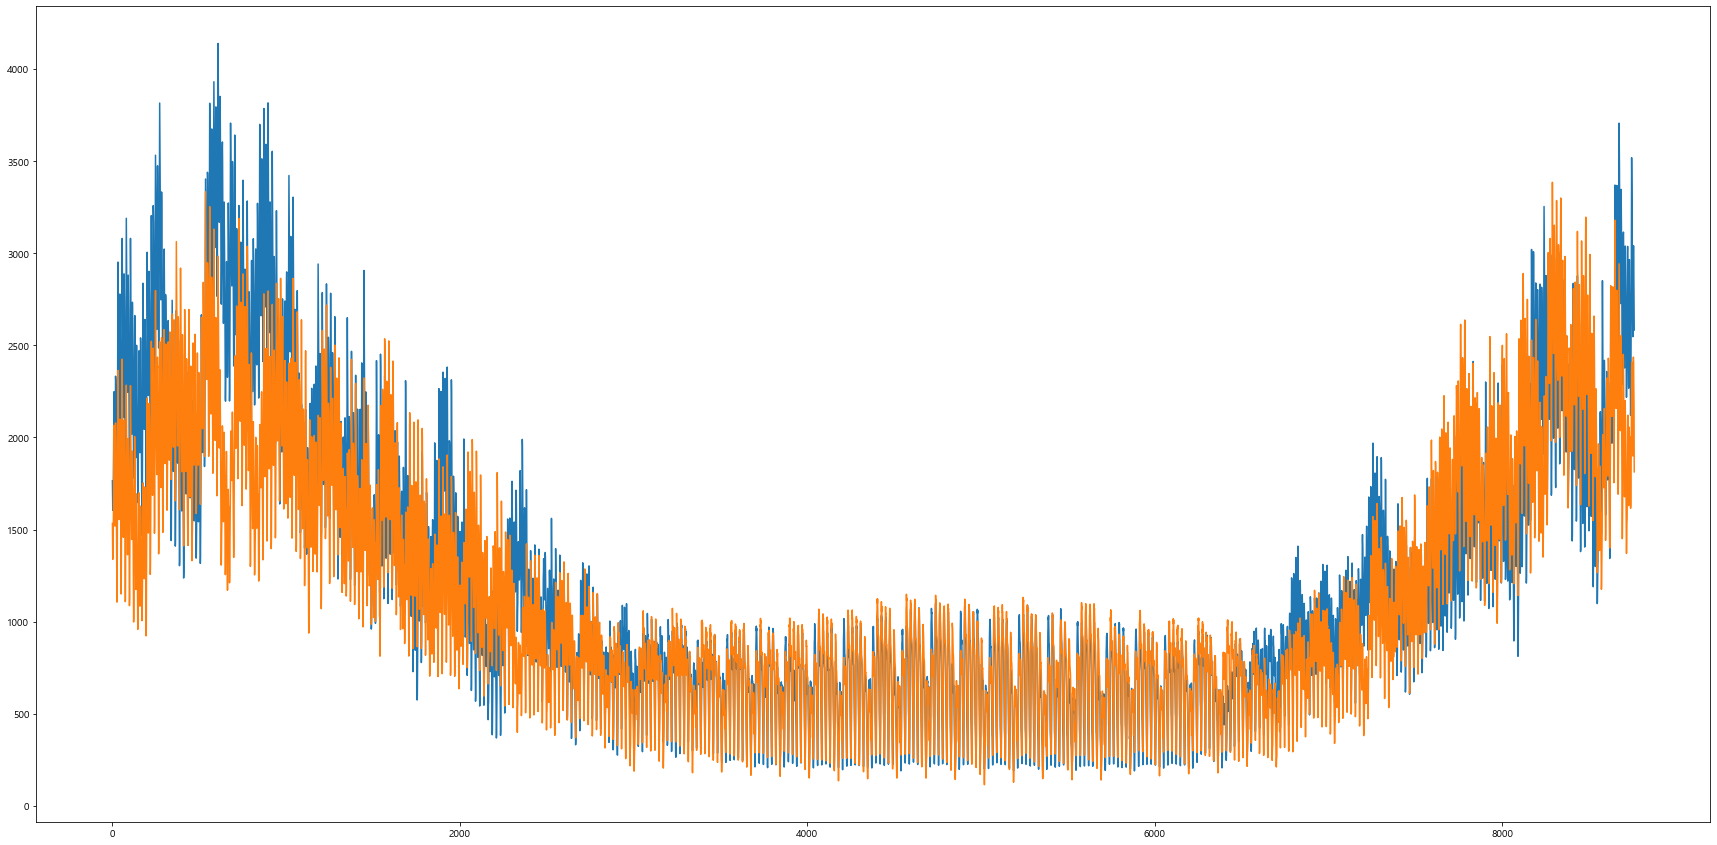

In [ ]:
fig = plt.figure(figsize = (30,15))
plt.plot(np.array(y_test))
plt.plot(y_pred)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor

In [ ]:
scaler = MinMaxScaler()
base_model =  XGBRegressor(n_estimators=250)

In [ ]:
pipe = Pipeline([('scaler', scaler),
               ('base_model', base_model)])

In [ ]:

# train, test = A_df_reg_final.iloc[:, 1:],  A_df_reg_final.iloc[:, 0]
X_train, X_test, y_train, y_test = train_test_split(train, test, random_state=2019, test_size=.25)
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('base_model',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, enable_categorical=False,
                              gamma=0, gpu_id=-1, importance_type=None,
                              interaction_constraints='',
                              learning_rate=0.300000012, max_delta_step=0,
                              max_depth=6, min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=250,
                              n_jobs=12, num_parallel_tree=1, predictor='auto',
                              random_state=0, reg_alpha=0, reg_lambda=1,
                              scale_pos_weight=1, subsample=1,
                              tree_method='exact', validate_parameters=1,
                              verbosity=None))])

In [ ]:
pred_xgb = pipe.predict(X_test)

In [ ]:
MAPE(y_test, pred_xgb)

11.35980568214306

## 전체 고객사 XGBOOST

In [ ]:
# supply_df = hour_time_series[0]
# supply_df = supply_df.reset_index().copy()
# supply_df['month'] = supply_df['index'].dt.month
# supply_df['day'] = supply_df['index'].dt.weekday
# supply_df['hour'] = supply_df['index'].dt.hour
# # 1년 전 땡기기
# supply_df['year_target'] = supply_df['target'].shift(8760)
# supply_df['temp_mean_rol_14'] = A_df_new['temp_mean_rol_14']

# # super 값 보정
# target_minmax = (supply_df['year_target'] - supply_df['year_target'].min()) / (supply_df['year_target'].max() - supply_df['year_target'].min())
# temp_minmax = (supply_df['temp_mean_rol_14'] - supply_df['temp_mean_rol_14'].min()) / (supply_df['temp_mean_rol_14'].max() - supply_df['temp_mean_rol_14'].min())
# alpha = 0.8
# supply_df['super'] = target_minmax * alpha + temp_minmax * (1-alpha)
# # holiday
# supply_df['holiday'] = ((supply_df['day'] == 5) | (supply_df['day'] == 6)).astype(int)

# supply_df = supply_df.drop(['index', 'temp_mean_rol_14', 'day', 'year_target'], axis=1)
# supply_df_reg_final = supply_df.dropna()

# train, test = supply_df_reg_final.iloc[:, 1:],  supply_df_reg_final.iloc[:, 0]
# X_train, X_test, y_train, y_test = train_test_split(train, test, shuffle=False, test_size=.25)
# print(supply_df_reg_final.corr())
# #계산 편하도록 dataframe -> nparray
# y_test = np.array(y_test)

# # model
# lr_model = XGBRegressor(n_estimators=250)
# lr_model.fit(X_train, y_train)
# y_pred = lr_model.predict(X_test)
# #score
# print(f"r2_score : {r2_score(y_test, y_pred)}")
# print(f"MAPE : {MAPE(y_test, y_pred.reshape(1,-1))}") 
# print(f"nmae : {nmae(y_test, y_pred.reshape(1,-1))}", end="\n\n") 

### 전체 모형 만들기

In [ ]:
supply_df_for_model = []
supply_statistics = []
for supply_df in hour_time_series:
    supply_df = supply_df.reset_index()
    
    supply_df['hour'] = supply_df['index'].dt.hour
    supply_df['weekday'] = supply_df['index'].dt.weekday
    supply_df['month'] = supply_df['index'].dt.month
    supply_df['week'] =  supply_df['index'].dt.weekofyear
    
    statistics, supply_df_new = to_mean_std(supply_df)
    
    # cyclical endocing(시간)
    supply_df_new['sin_time'] = np.sin(2*np.pi*supply_df_new.hour/24)
    supply_df_new['cos_time'] = np.cos(2*np.pi*supply_df_new.hour/24)
    
    # append
    supply_statistics.append(statistics)
    
    #t_year
    supply_df_new['t_year_target'] = supply_df_new['target'].shift(8760)
    
    supply_df_for_model.append(supply_df_new)

    
supply_df_for_model[0]    

100%|██████████| 52560/52560 [00:11<00:00, 4650.61it/s]


,index,target,hour,weekday,month,week,week_hour_mean,hour_mean,week_mean,week_hour_std,hour_std,week_std,sin_time,cos_time,t_year_target
0,2013-01-01 01:00:00,2497.129,1,1,1,1,985.318879,972.691102,1214.538089,683.467117,682.527452,748.659908,0.258819,0.965926,NaN
1,2013-01-01 02:00:00,2363.265,2,1,1,1,820.722869,814.406044,1214.538089,621.134014,621.372188,748.659908,0.500000,0.866025,NaN
2,2013-01-01 03:00:00,2258.505,3,1,1,1,739.991268,732.084785,1214.538089,592.160976,591.522969,748.659908,0.707107,0.707107,NaN
3,2013-01-01 04:00:00,2243.969,4,1,1,1,759.796850,748.616821,1214.538089,615.631825,612.737636,748.659908,0.866025,0.500000,NaN
4,2013-01-01 05:00:00,2344.105,5,1,1,1,884.006300,864.506598,1214.538089,669.569657,662.903535,748.659908,0.965926,0.258819,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52555,2018-12-31 20:00:00,3040.868,20,0,12,1,1429.954962,1390.106345,1190.477563,814.191147,806.991797,748.076828,-0.866025,0.500000,2233.357
52556,2018-12-31 21:00:00,2973.577,21,0,12,1,1386.927670,1341.410033,1190.477563,814.218438,798.125458,748.076828,-0.707107,0.707107,2134.898
52557,2018-12-31 22:00:00,2840.272,22,0,12,1,1324.742833,1274.464524,1190.477563,816.488701,799.581287,748.076828,-0.500000,0.866025,2054.192
52558,2018-12-31 23:00:00,2692.385,23,0,12,1,1228.134423,1192.344977,1190.477563,797.617646,784.087273,748.076828,-0.258819,0.965926,1981.397


In [ ]:
supply_df_final = []

for supply_df in supply_df_for_model:
    supply_df = supply_df.drop(['week_mean', 'week_std', 't_year_target',], axis=1)
    supply_df_final.append(supply_df.dropna().reset_index(drop=True))

supply_df_final[0].head()

,index,target,hour,weekday,month,week,week_hour_mean,hour_mean,week_hour_std,hour_std,sin_time,cos_time
0,2013-01-01 01:00:00,2497.129,1,1,1,1,985.318879,972.691102,683.467117,682.527452,0.258819,0.965926
1,2013-01-01 02:00:00,2363.265,2,1,1,1,820.722869,814.406044,621.134014,621.372188,0.500000,0.866025
2,2013-01-01 03:00:00,2258.505,3,1,1,1,739.991268,732.084785,592.160976,591.522969,0.707107,0.707107
3,2013-01-01 04:00:00,2243.969,4,1,1,1,759.796850,748.616821,615.631825,612.737636,0.866025,0.500000
4,2013-01-01 05:00:00,2344.105,5,1,1,1,884.006300,864.506598,669.569657,662.903535,0.965926,0.258819


In [ ]:
models = []
final_df_list = []
nmae_total = 0
for supply_df in supply_df_final:

    #train, test data
    X, y =supply_df.iloc[:, 3:], supply_df.iloc[:, 1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2019, test_size=.20)
    
    #계산 편하도록 dataframe -> nparray
    y_test = np.array(y_test)
    
    #Pipeline 제작
    scaler = MinMaxScaler()
    base_model = XGBRegressor(n_estimators=100)
    pipe = Pipeline([('scaler', scaler),
               ('base_model', base_model)])
    
    # GridSearchCV의 param_grid 설정
    params = {
#         'base_model__nmax_depth': [2, 3,4, 5],
#         'base_model__min_samples_split': [2, 3],
#         'base_model__n_estimators' : list(range(100, 301, 50))
    }

    grid_tree = GridSearchCV(estimator=pipe,
                             param_grid=params,
                             cv=5,
                             refit=True,
                             scoring='neg_mean_absolute_error')
    
    grid_tree.fit(X_train, y_train)
    
    # score
    print('best parameters : ', grid_tree.best_params_)
    print('best score : ', grid_tree.best_score_)
    
    y_pred = grid_tree.predict(X_test)
    
    #score
    print(f"r2_score : {r2_score(y_test, y_pred)}")
    print(f"MAPE : {MAPE(y_test, y_pred.reshape(1,-1))}") 
    print(f"nmae : {nmae(y_test, y_pred.reshape(1,-1))}", end="\n\n") 
    
    nmae_total += nmae(y_test, y_pred.reshape(1,-1))
    models.append(grid_tree) 

best parameters :  {}
best score :  -138.19378288713096
r2_score : 0.9128702658572889
MAPE : 10.963810104029534
nmae : 0.10963810104029534

best parameters :  {}
best score :  -119.9501655415443
r2_score : 0.9201180373312916
MAPE : 11.95042459454207
nmae : 0.11950424594542071

best parameters :  {}
best score :  -17.09980373039802
r2_score : 0.8129819225681163
MAPE : 13.390273341022885
nmae : 0.13390273341022885

best parameters :  {}
best score :  -76.82012595930023
r2_score : 0.9283979650771449
MAPE : 11.421336928878254
nmae : 0.11421336928878255

best parameters :  {}
best score :  -176.13688251061313
r2_score : 0.9140740598578473
MAPE : 11.827903941539782
nmae : 0.11827903941539783

best parameters :  {}
best score :  -217.32852802855027
r2_score : 0.9006295891110151
MAPE : 10.18845280538992
nmae : 0.10188452805389919

best parameters :  {}
best score :  -28.971123443634127
r2_score : 0.9271125329712464
MAPE : 11.302237350208737
nmae : 0.11302237350208737



In [ ]:
nmae_total/7

# 0.10213968248553869 after grid_search with 
# 0.11577777009373025 after min_max scaler(no t_year)
# 0.10317329501381996 after min_max scaler(with t_year)

0.11577777009373025

In [ ]:
#합쳐서 학습

In [ ]:
all_df = pd.DataFrame(columns = supply_df_final[0].columns)
all_df
for i, supply_df in enumerate(supply_df_final):
    supply_df['supply'] = i
    all_df = pd.concat([all_df, supply_df], axis=0)

# all_df.drop(['hour_mean', ])
all_df.corr()

,target,week_hour_mean,hour_mean,week_hour_std,hour_std,sin_time,cos_time,supply
target,1.000000,0.715145,0.709053,0.667194,0.665657,-5.747690e-02,-6.373754e-02,5.614122e-02
week_hour_mean,0.715145,1.000000,0.991482,0.932950,0.930800,-8.037101e-02,-8.912538e-02,7.850330e-02
hour_mean,0.709053,0.991482,1.000000,0.931183,0.938797,-8.106146e-02,-8.989103e-02,7.917770e-02
week_hour_std,0.667194,0.932950,0.931183,1.000000,0.996074,2.180460e-02,8.060209e-02,-9.951197e-03
hour_std,0.665657,0.930800,0.938797,0.996074,1.000000,2.445132e-02,7.701119e-02,-5.739756e-03
sin_time,-0.057477,-0.080371,-0.081061,0.021805,0.024451,1.000000e+00,-2.314767e-17,5.254124e-19
cos_time,-0.063738,-0.089125,-0.089891,0.080602,0.077011,-2.314767e-17,1.000000e+00,1.253787e-18
supply,0.056141,0.078503,0.079178,-0.009951,-0.005740,5.254124e-19,1.253787e-18,1.000000e+00


In [ ]:
model_one = []
final_df_list = []
nmae_total = 0


#train, test data
X, y =all_df.iloc[:, 3:], all_df.iloc[:, 1]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2019, test_size=.20)
print(X_train.shape)
#계산 편하도록 dataframe -> nparray
y_test = np.array(y_test)

#Pipeline 제작
scaler = MinMaxScaler()
base_model = XGBRegressor(n_estimators=100)
pipe = Pipeline([('scaler', scaler),
           ('base_model', base_model)])

# GridSearchCV의 param_grid 설정
params = {
#         'base_model__nmax_depth': [2, 3,4, 5],
#         'base_model__min_samples_split': [2, 3],
#         'base_model__n_estimators' : list(range(100, 301, 50))
}

grid_tree = GridSearchCV(estimator=pipe,
                         param_grid=params,
                         cv=5,
                         refit=True,
                         scoring='neg_mean_absolute_error')

grid_tree.fit(X_train, y_train)

# score
print('best parameters : ', grid_tree.best_params_)
print('best score : ', grid_tree.best_score_)

y_pred = grid_tree.predict(X_test)

#score
print(f"r2_score : {r2_score(y_test, y_pred)}")
print(f"MAPE : {MAPE(y_test, y_pred.reshape(1,-1))}") 
print(f"nmae : {nmae(y_test, y_pred.reshape(1,-1))}", end="\n\n") 

nmae_total += nmae(y_test, y_pred.reshape(1,-1))
model_one.append(grid_tree) 

best parameters :  {}
best score :  -107.41203589132427
r2_score : 0.95534776680597
MAPE : 11.96895846270278
nmae : 0.1196895846270278



In [ ]:
features_all = X_train.columns.tolist()
features_all

['weekday',
 'month',
 'week',
 'week_hour_mean',
 'hour_mean',
 'week_hour_std',
 'hour_std',
 'sin_time',
 'cos_time',
 'supply']

In [ ]:
# ft_importance_values = models[4].feature_importances_

# ft_series = pd.Series(ft_importance_values, index = X_train.columns)
# ft_top4 = ft_series.sort_values(ascending=False)

# # 시각화
# plt.figure(figsize=(8,6))
# plt.title('d')
# sns.barplot(x=ft_top4, y=ft_top4.index)
# plt.show()

In [ ]:
features = list(X_train.columns)
features

['weekday',
 'month',
 'week',
 'week_hour_mean',
 'hour_mean',
 'week_hour_std',
 'hour_std',
 'sin_time',
 'cos_time']

## test

In [ ]:
test = pd.read_csv('data/test.csv')
submission = pd.read_csv('data/sample_submission.csv')

In [ ]:
test.head()


,일자|시간|구분
0,2019-01-01 01 A
1,2019-01-01 02 A
2,2019-01-01 03 A
3,2019-01-01 04 A
4,2019-01-01 05 A


In [ ]:
submission.head()


,일자|시간|구분,공급량
0,2019-01-01 01 A,0
1,2019-01-01 02 A,0
2,2019-01-01 03 A,0
3,2019-01-01 04 A,0
4,2019-01-01 05 A,0


In [ ]:
test['일자'] = test['일자|시간|구분'].str.split(' ').str[0]
test['시간'] = test['일자|시간|구분'].str.split(' ').str[1].astype(int)
test['구분'] = test['일자|시간|구분'].str.split(' ').str[2]

In [ ]:
test[:26]

,일자|시간|구분,일자,시간,구분
0,2019-01-01 01 A,2019-01-01,1,A
1,2019-01-01 02 A,2019-01-01,2,A
2,2019-01-01 03 A,2019-01-01,3,A
3,2019-01-01 04 A,2019-01-01,4,A
4,2019-01-01 05 A,2019-01-01,5,A
5,2019-01-01 06 A,2019-01-01,6,A
6,2019-01-01 07 A,2019-01-01,7,A
7,2019-01-01 08 A,2019-01-01,8,A
8,2019-01-01 09 A,2019-01-01,9,A
9,2019-01-01 10 A,2019-01-01,10,A


In [ ]:
time_index[:26]

DatetimeIndex(['2013-01-01 01:00:00', '2013-01-01 02:00:00',
               '2013-01-01 03:00:00', '2013-01-01 04:00:00',
               '2013-01-01 05:00:00', '2013-01-01 06:00:00',
               '2013-01-01 07:00:00', '2013-01-01 08:00:00',
               '2013-01-01 09:00:00', '2013-01-01 10:00:00',
               '2013-01-01 11:00:00', '2013-01-01 12:00:00',
               '2013-01-01 13:00:00', '2013-01-01 14:00:00',
               '2013-01-01 15:00:00', '2013-01-01 16:00:00',
               '2013-01-01 17:00:00', '2013-01-01 18:00:00',
               '2013-01-01 19:00:00', '2013-01-01 20:00:00',
               '2013-01-01 21:00:00', '2013-01-01 22:00:00',
               '2013-01-01 23:00:00', '2013-01-02 00:00:00',
               '2013-01-02 01:00:00', '2013-01-02 02:00:00'],
              dtype='datetime64[ns]', freq=None)

In [ ]:
# time series작업을 해 주는 이유는, 하루가 넘어갈 때 차이가 넘어가는 경우 발생해서 통일해줘야
time_series = pd.Series()
ss = pd.Series(time_index[:2160], name='time')
for i in range(7):
    time_series = time_series.append(ss).reset_index(drop=True)
time_series

0       2013-01-01 01:00:00
1       2013-01-01 02:00:00
2       2013-01-01 03:00:00
3       2013-01-01 04:00:00
4       2013-01-01 05:00:00
                ...        
15115   2013-03-31 20:00:00
15116   2013-03-31 21:00:00
15117   2013-03-31 22:00:00
15118   2013-03-31 23:00:00
15119   2013-04-01 00:00:00
Length: 15120, dtype: datetime64[ns]

In [ ]:
test['일자'] = time_series
# test['year'] = test['일자'].dt.year
test['year'] = test['일자'].dt.year
test['weekday'] = test['일자'].dt.weekday
test['month'] = test['일자'].dt.month
test['week'] = test['일자'].dt.weekofyear
test['hour'] = test['일자'].dt.hour

In [ ]:
test

,일자|시간|구분,일자,시간,구분,year,weekday,month,week,hour
0,2019-01-01 01 A,2013-01-01 01:00:00,1,A,2013,1,1,1,1
1,2019-01-01 02 A,2013-01-01 02:00:00,2,A,2013,1,1,1,2
2,2019-01-01 03 A,2013-01-01 03:00:00,3,A,2013,1,1,1,3
3,2019-01-01 04 A,2013-01-01 04:00:00,4,A,2013,1,1,1,4
4,2019-01-01 05 A,2013-01-01 05:00:00,5,A,2013,1,1,1,5
...,...,...,...,...,...,...,...,...,...
15115,2019-03-31 20 H,2013-03-31 20:00:00,20,H,2013,6,3,13,20
15116,2019-03-31 21 H,2013-03-31 21:00:00,21,H,2013,6,3,13,21
15117,2019-03-31 22 H,2013-03-31 22:00:00,22,H,2013,6,3,13,22
15118,2019-03-31 23 H,2013-03-31 23:00:00,23,H,2013,6,3,13,23


In [ ]:
features
# [power_week_hour_mean, power_hour_mean, power_week_mean, power_week_hour_std, power_hour_std, power_week_std]
# statistics index = 0,1,3,4

['weekday',
 'month',
 'week',
 'week_hour_mean',
 'hour_mean',
 'week_hour_std',
 'hour_std',
 'sin_time',
 'cos_time']

In [ ]:
test_df_list=[]
for col, supply_df in zip(test['구분'].unique(), hour_time_series):
    tmp_df = test[test['구분'] == col].reset_index(drop=True)
    
    #1년 전 데이터(2018) 붙이기
    tmp_df['t_year_target'] = supply_df['target'][-8760:-8760+2160].reset_index(drop=True)
    test_df_list.append(tmp_df)
len(test_df_list)

7

In [ ]:
test_df_with_mean = []
for test_df, info in zip(test_df_list, supply_statistics):
    power_week_hour_mean = info[0]
    power_hour_mean = info[1]
    power_week_hour_std = info[3]
    power_hour_std = info[4]
    
    tqdm.pandas()
    test_df['week_hour_mean'] = test_df.progress_apply(lambda x : power_week_hour_mean.loc[(power_week_hour_mean.weekday == x['weekday']) & (power_week_hour_mean.hour == x['hour']) ,'target'].values[0], axis = 1)
    tqdm.pandas()
    test_df['hour_mean'] = test_df.progress_apply(lambda x : power_hour_mean.loc[(power_hour_mean.hour == x['hour']) ,'target'].values[0], axis = 1)
    tqdm.pandas()
    test_df['week_hour_std'] = test_df.progress_apply(lambda x : power_week_hour_std.loc[(power_week_hour_std.weekday == x['weekday']) & (power_week_hour_std.hour == x['hour']) ,'target'].values[0], axis = 1)
    tqdm.pandas()
    test_df['hour_std'] = test_df.progress_apply(lambda x : power_hour_std.loc[(power_hour_std.hour == x['hour']) ,'target'].values[0], axis = 1)
    
    test_df['sin_time'] = np.sin(2*np.pi*test_df.hour/24)
    test_df['cos_time'] = np.cos(2*np.pi*test_df.hour/24)
    
    test_df_with_mean.append(test_df)


100%|██████████| 2160/2160 [00:00<00:00, 4618.37it/s]


In [ ]:
test_df_final = []
for test_df in test_df_with_mean:
    test_df_final.append(test_df[features])

test_df_final[0]

,weekday,month,week,week_hour_mean,hour_mean,week_hour_std,hour_std,sin_time,cos_time
0,1,1,1,985.318879,972.691102,683.467117,682.527452,0.258819,0.965926
1,1,1,1,820.722869,814.406044,621.134014,621.372188,0.500000,0.866025
2,1,1,1,739.991268,732.084785,592.160976,591.522969,0.707107,0.707107
3,1,1,1,759.796850,748.616821,615.631825,612.737636,0.866025,0.500000
4,1,1,1,884.006300,864.506598,669.569657,662.903535,0.965926,0.258819
...,...,...,...,...,...,...,...,...,...
2155,6,3,13,1303.260572,1390.106345,784.131139,806.991797,-0.866025,0.500000
2156,6,3,13,1251.071780,1341.410033,759.911639,798.125458,-0.707107,0.707107
2157,6,3,13,1177.302403,1274.464524,753.284721,799.581287,-0.500000,0.866025
2158,6,3,13,1099.235987,1192.344977,737.679293,784.087273,-0.258819,0.965926


In [ ]:
y_pred_list = []
for test_df, model in zip(test_df_final, models):
    y_pred = model.predict(test_df)
    y_pred_list.append(y_pred)
    

In [ ]:
y_pred_list

[array([1806.9745, 1633.4479, 1555.5807, ..., 1323.3904, 1214.5723,
         955.6998], dtype=float32),
 array([1595.1715 , 1443.4022 , 1363.1068 , ..., 1189.616  , 1058.9675 ,
         867.68506], dtype=float32),
 array([191.47995, 182.31401, 176.03226, ..., 155.0925 , 140.75696,
        125.81736], dtype=float32),
 array([1044.6338 ,  972.6486 ,  911.2286 , ...,  799.53296,  676.7858 ,
         571.4009 ], dtype=float32),
 array([2399.234 , 2156.966 , 1998.7151, ..., 1818.9572, 1709.6122,
        1326.5297], dtype=float32),
 array([2838.4338, 2599.7065, 2478.095 , ..., 2151.3423, 2024.64  ,
        1725.5951], dtype=float32),
 array([408.99957, 371.71   , 334.26514, ..., 334.6405 , 285.0769 ,
        220.89954], dtype=float32)]

In [ ]:
all_values = []
for supply_list in y_pred_list:
    for value in supply_list:
        all_values.append(value)

In [ ]:
submission['공급량'] = all_values

<AxesSubplot:>

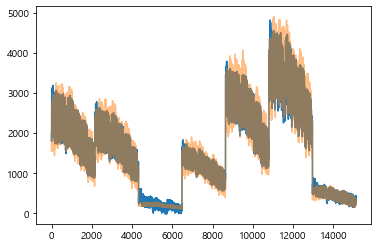

In [ ]:
baseline.plot()
submission['공급량'].plot(alpha=0.5)

In [ ]:
# 저장
submission.to_csv("XGBoost_without_t_year.csv", index=False)

In [ ]:
# t_year 있는거랑 비교
baseline = pd.read_csv('data/baseline.csv')['공급량']
xgboost_first = pd.read_csv('XGBoost_first.csv')['공급량']
xgboost_with_t_year = pd.read_csv('XGBoost_mean_std.csv')['공급량']
# xgboost_without = 
mean = pd.read_csv('mean.csv')['공급량']

<AxesSubplot:>

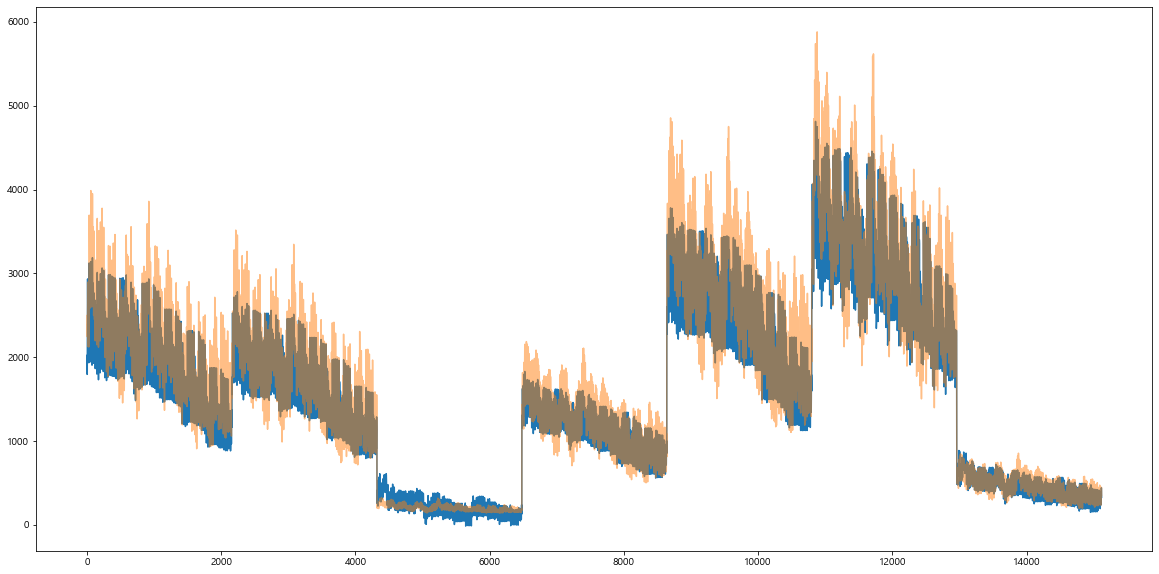

In [ ]:
plt.figure(figsize=(20,10))

baseline.plot()
mean.plot(alpha=0.5)

<AxesSubplot:>

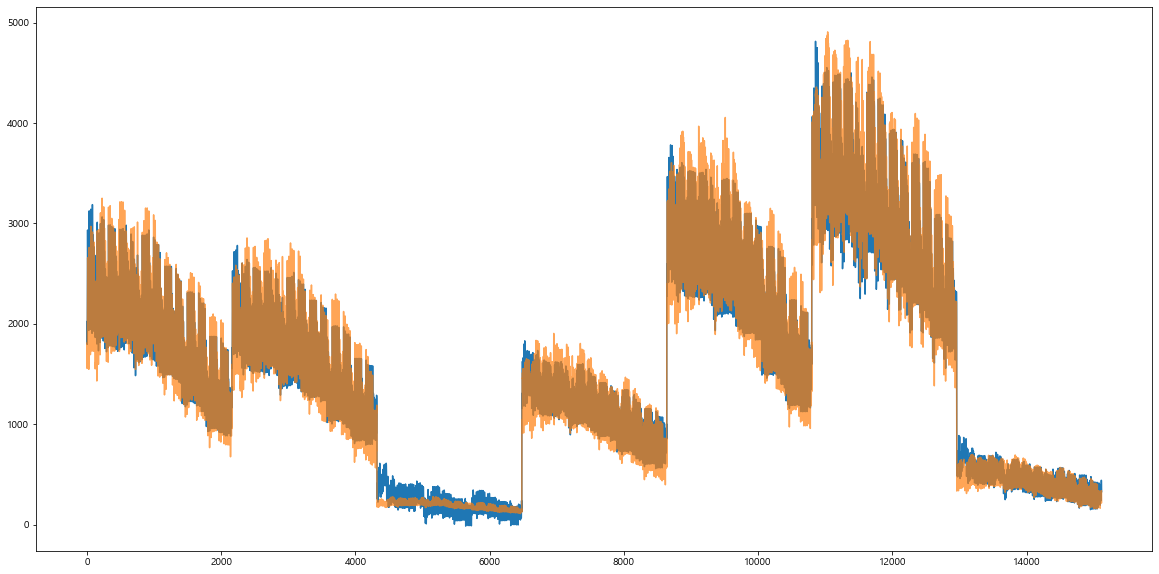

In [ ]:
plt.figure(figsize=(20,10))

baseline.plot()
# xgboost_with_t_year.plot(alpha=1)
xgboost_without.plot(alpha=0.7)


<AxesSubplot:>

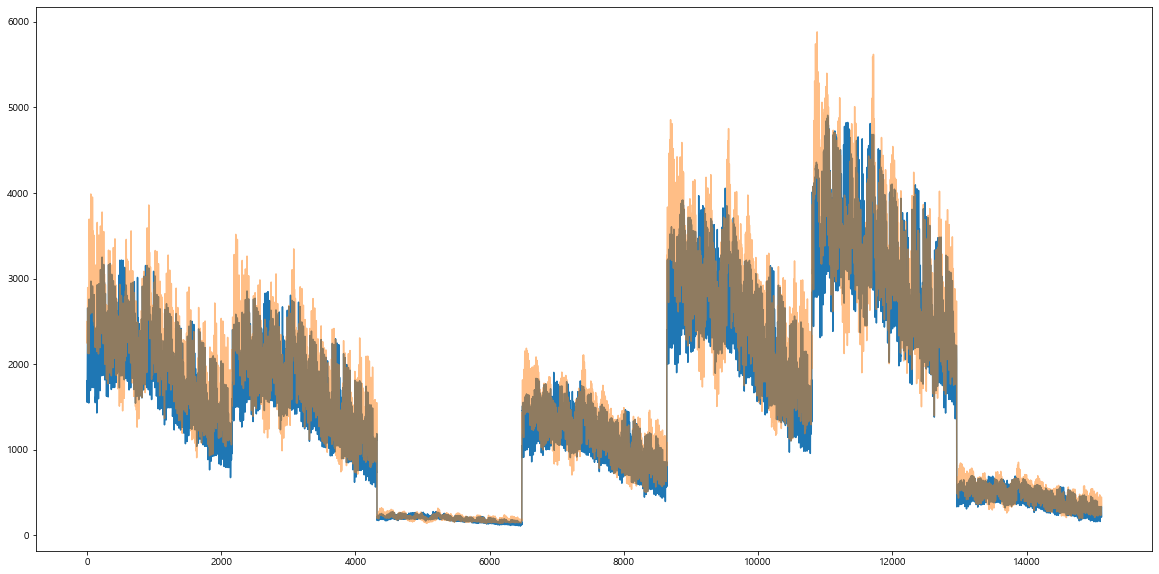

In [ ]:
plt.figure(figsize=(20,10))

xgboost_without.plot()
mean.plot(alpha=0.5)

<AxesSubplot:>

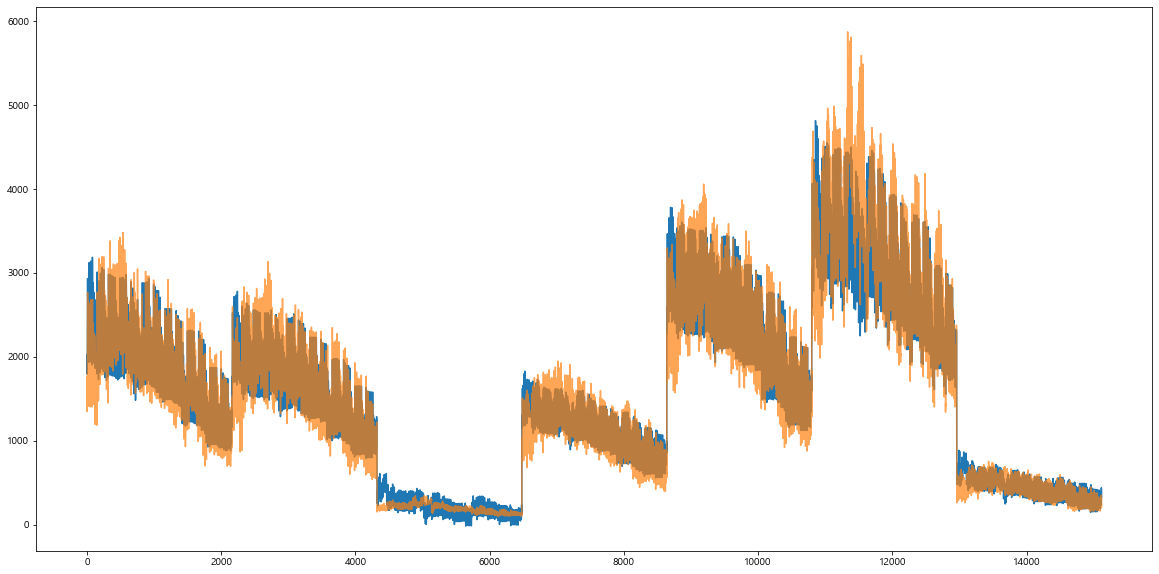

In [ ]:
plt.figure(figsize=(20,10))

baseline.plot()
xgboost_with_t_year.plot(alpha=0.7)


<AxesSubplot:>

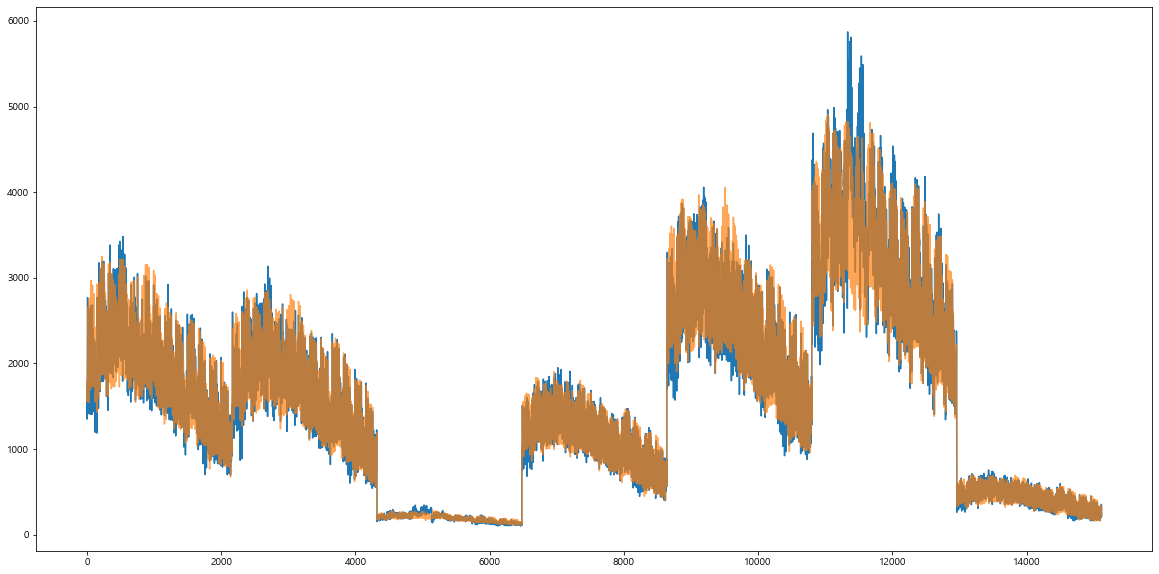

In [ ]:
plt.figure(figsize=(20,10))
xgboost_with_t_year.plot()
xgboost_without.plot(alpha=0.7)

<AxesSubplot:>

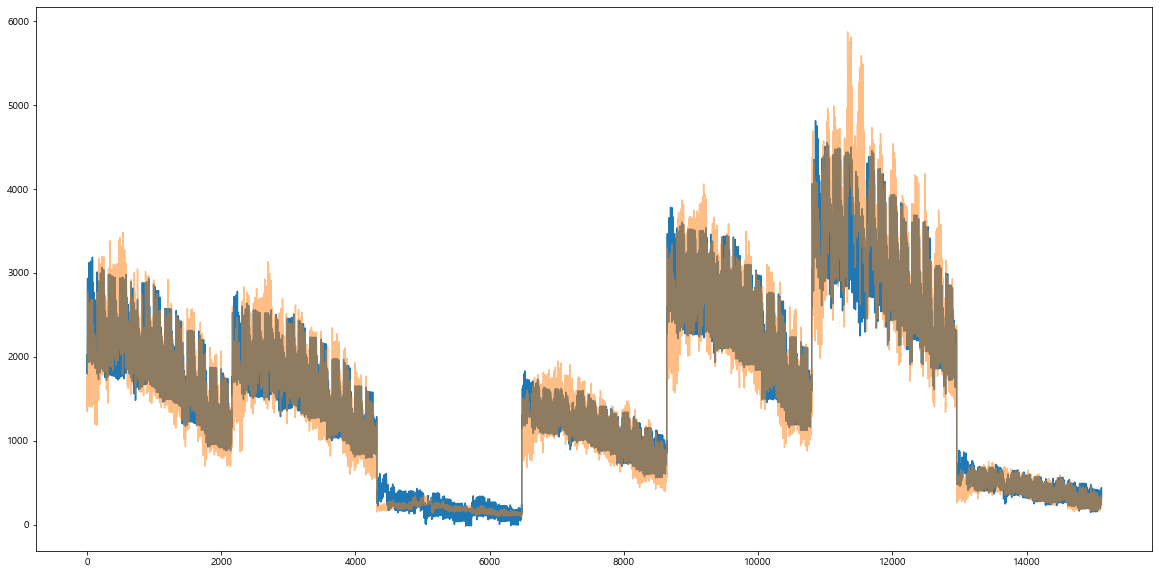

In [ ]:
plt.figure(figsize=(20,10))
baseline.plot()
xgboost_with_t_year.plot(alpha=0.5)

<AxesSubplot:>

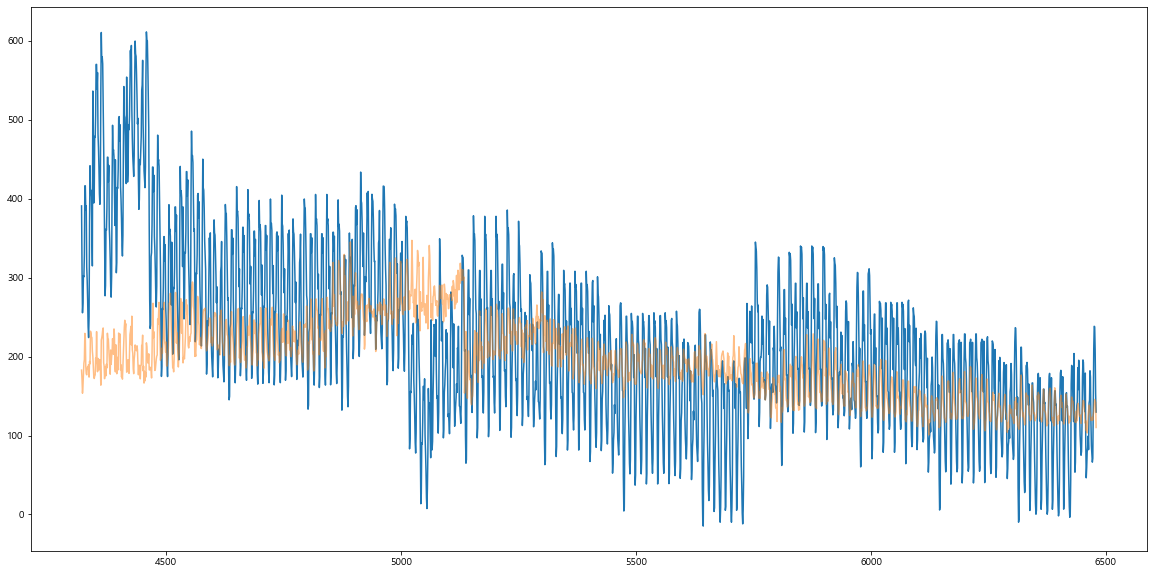

In [ ]:
plt.figure(figsize=(20,10))
baseline[2160*2:2160*3].plot()
xgboost_with_t_year[2160*2:2160*3].plot(alpha=0.5)

<AxesSubplot:>

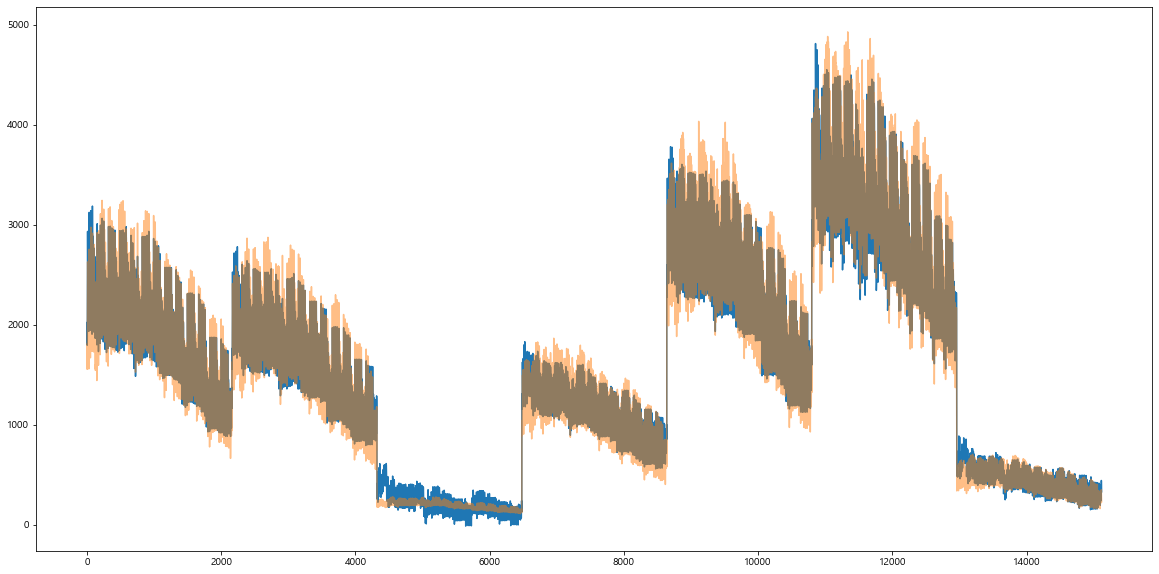

In [ ]:
plt.figure(figsize=(20,10))
baseline.plot()
xgboost_without.plot(alpha=0.5)

## test_하나

In [ ]:
test = pd.read_csv('data/test.csv')
submission = pd.read_csv('data/sample_submission.csv')

In [ ]:
test.head()


,일자|시간|구분
0,2019-01-01 01 A
1,2019-01-01 02 A
2,2019-01-01 03 A
3,2019-01-01 04 A
4,2019-01-01 05 A


In [ ]:
submission.head()


,일자|시간|구분,공급량
0,2019-01-01 01 A,0
1,2019-01-01 02 A,0
2,2019-01-01 03 A,0
3,2019-01-01 04 A,0
4,2019-01-01 05 A,0


In [ ]:
test['일자'] = test['일자|시간|구분'].str.split(' ').str[0]
test['시간'] = test['일자|시간|구분'].str.split(' ').str[1].astype(int)
test['supply'] = test['일자|시간|구분'].str.split(' ').str[2]

In [ ]:
test['supply'] = test['supply'].map(d_map)
test

,일자|시간|구분,일자,시간,supply
0,2019-01-01 01 A,2019-01-01,1,0
1,2019-01-01 02 A,2019-01-01,2,0
2,2019-01-01 03 A,2019-01-01,3,0
3,2019-01-01 04 A,2019-01-01,4,0
4,2019-01-01 05 A,2019-01-01,5,0
...,...,...,...,...
15115,2019-03-31 20 H,2019-03-31,20,6
15116,2019-03-31 21 H,2019-03-31,21,6
15117,2019-03-31 22 H,2019-03-31,22,6
15118,2019-03-31 23 H,2019-03-31,23,6


In [ ]:
time_index[:26]

DatetimeIndex(['2013-01-01 01:00:00', '2013-01-01 02:00:00',
               '2013-01-01 03:00:00', '2013-01-01 04:00:00',
               '2013-01-01 05:00:00', '2013-01-01 06:00:00',
               '2013-01-01 07:00:00', '2013-01-01 08:00:00',
               '2013-01-01 09:00:00', '2013-01-01 10:00:00',
               '2013-01-01 11:00:00', '2013-01-01 12:00:00',
               '2013-01-01 13:00:00', '2013-01-01 14:00:00',
               '2013-01-01 15:00:00', '2013-01-01 16:00:00',
               '2013-01-01 17:00:00', '2013-01-01 18:00:00',
               '2013-01-01 19:00:00', '2013-01-01 20:00:00',
               '2013-01-01 21:00:00', '2013-01-01 22:00:00',
               '2013-01-01 23:00:00', '2013-01-02 00:00:00',
               '2013-01-02 01:00:00', '2013-01-02 02:00:00'],
              dtype='datetime64[ns]', freq=None)

In [ ]:
# time series작업을 해 주는 이유는, 하루가 넘어갈 때 차이가 넘어가는 경우 발생해서 통일해줘야
time_series = pd.Series()
ss = pd.Series(time_index[:2160], name='time')
for i in range(7):
    time_series = time_series.append(ss).reset_index(drop=True)
time_series

0       2013-01-01 01:00:00
1       2013-01-01 02:00:00
2       2013-01-01 03:00:00
3       2013-01-01 04:00:00
4       2013-01-01 05:00:00
                ...        
15115   2013-03-31 20:00:00
15116   2013-03-31 21:00:00
15117   2013-03-31 22:00:00
15118   2013-03-31 23:00:00
15119   2013-04-01 00:00:00
Length: 15120, dtype: datetime64[ns]

In [ ]:
test['일자'] = time_series
# test['year'] = test['일자'].dt.year
test['year'] = test['일자'].dt.year
test['weekday'] = test['일자'].dt.weekday
test['month'] = test['일자'].dt.month
test['week'] = test['일자'].dt.weekofyear
test['hour'] = test['일자'].dt.hour

In [ ]:
test

,일자|시간|구분,일자,시간,supply,year,weekday,month,week,hour
0,2019-01-01 01 A,2013-01-01 01:00:00,1,0,2013,1,1,1,1
1,2019-01-01 02 A,2013-01-01 02:00:00,2,0,2013,1,1,1,2
2,2019-01-01 03 A,2013-01-01 03:00:00,3,0,2013,1,1,1,3
3,2019-01-01 04 A,2013-01-01 04:00:00,4,0,2013,1,1,1,4
4,2019-01-01 05 A,2013-01-01 05:00:00,5,0,2013,1,1,1,5
...,...,...,...,...,...,...,...,...,...
15115,2019-03-31 20 H,2013-03-31 20:00:00,20,6,2013,6,3,13,20
15116,2019-03-31 21 H,2013-03-31 21:00:00,21,6,2013,6,3,13,21
15117,2019-03-31 22 H,2013-03-31 22:00:00,22,6,2013,6,3,13,22
15118,2019-03-31 23 H,2013-03-31 23:00:00,23,6,2013,6,3,13,23


In [ ]:
features_all
# [power_week_hour_mean, power_hour_mean, power_week_mean, power_week_hour_std, power_hour_std, power_week_std]
# statistics index = 0,1,3,4

['weekday',
 'month',
 'week',
 'week_hour_mean',
 'hour_mean',
 'week_hour_std',
 'hour_std',
 'sin_time',
 'cos_time',
 'supply']

In [ ]:
test_df_list=[]
for col, supply_df in zip(test['supply'].unique(), hour_time_series):
    tmp_df = test[test['supply'] == col].reset_index(drop=True)
    
    #1년 전 데이터(2018) 붙이기
    tmp_df['t_year_target'] = supply_df['target'][-8760:-8760+2160].reset_index(drop=True)
    test_df_list.append(tmp_df)
len(test_df_list)

7

In [ ]:
test_df_with_mean = []
for test_df, info in zip(test_df_list, supply_statistics):
    power_week_hour_mean = info[0]
    power_hour_mean = info[1]
    power_week_hour_std = info[3]
    power_hour_std = info[4]
    
    tqdm.pandas()
    test_df['week_hour_mean'] = test_df.progress_apply(lambda x : power_week_hour_mean.loc[(power_week_hour_mean.weekday == x['weekday']) & (power_week_hour_mean.hour == x['hour']) ,'target'].values[0], axis = 1)
    tqdm.pandas()
    test_df['hour_mean'] = test_df.progress_apply(lambda x : power_hour_mean.loc[(power_hour_mean.hour == x['hour']) ,'target'].values[0], axis = 1)
    tqdm.pandas()
    test_df['week_hour_std'] = test_df.progress_apply(lambda x : power_week_hour_std.loc[(power_week_hour_std.weekday == x['weekday']) & (power_week_hour_std.hour == x['hour']) ,'target'].values[0], axis = 1)
    tqdm.pandas()
    test_df['hour_std'] = test_df.progress_apply(lambda x : power_hour_std.loc[(power_hour_std.hour == x['hour']) ,'target'].values[0], axis = 1)
    
    test_df['sin_time'] = np.sin(2*np.pi*test_df.hour/24)
    test_df['cos_time'] = np.cos(2*np.pi*test_df.hour/24)
    
    test_df_with_mean.append(test_df)


100%|██████████| 2160/2160 [00:00<00:00, 4990.23it/s]


In [ ]:
test_df_final = []
for test_df in test_df_with_mean:
    test_df_final.append(test_df[features_all])

test_df_final[0]

,weekday,month,week,week_hour_mean,hour_mean,week_hour_std,hour_std,sin_time,cos_time,supply
0,1,1,1,985.318879,972.691102,683.467117,682.527452,0.258819,0.965926,0
1,1,1,1,820.722869,814.406044,621.134014,621.372188,0.500000,0.866025,0
2,1,1,1,739.991268,732.084785,592.160976,591.522969,0.707107,0.707107,0
3,1,1,1,759.796850,748.616821,615.631825,612.737636,0.866025,0.500000,0
4,1,1,1,884.006300,864.506598,669.569657,662.903535,0.965926,0.258819,0
...,...,...,...,...,...,...,...,...,...,...
2155,6,3,13,1303.260572,1390.106345,784.131139,806.991797,-0.866025,0.500000,0
2156,6,3,13,1251.071780,1341.410033,759.911639,798.125458,-0.707107,0.707107,0
2157,6,3,13,1177.302403,1274.464524,753.284721,799.581287,-0.500000,0.866025,0
2158,6,3,13,1099.235987,1192.344977,737.679293,784.087273,-0.258819,0.965926,0


In [ ]:
all_df = pd.DataFrame(columns = test_df_final[0].columns)
all_df
for i, supply_df in enumerate(test_df_final):
    all_df = pd.concat([all_df, supply_df], axis=0, ignore_index=True)

all_df

,weekday,month,week,week_hour_mean,hour_mean,week_hour_std,hour_std,sin_time,cos_time,supply
0,1,1,1,985.318879,972.691102,683.467117,682.527452,0.258819,0.965926,0
1,1,1,1,820.722869,814.406044,621.134014,621.372188,0.500000,0.866025,0
2,1,1,1,739.991268,732.084785,592.160976,591.522969,0.707107,0.707107,0
3,1,1,1,759.796850,748.616821,615.631825,612.737636,0.866025,0.500000,0
4,1,1,1,884.006300,864.506598,669.569657,662.903535,0.965926,0.258819,0
...,...,...,...,...,...,...,...,...,...,...
15115,6,3,13,299.392013,310.231290,191.771770,198.337399,-0.866025,0.500000,6
15116,6,3,13,293.165396,310.669847,191.988834,202.362701,-0.707107,0.707107,6
15117,6,3,13,270.111748,292.929209,187.240714,202.066964,-0.500000,0.866025,6
15118,6,3,13,243.841073,266.118172,178.918875,194.785077,-0.258819,0.965926,6


In [ ]:
model_for_all = model_one[0]
pred = model_for_all.predict(all_df)

<AxesSubplot:>

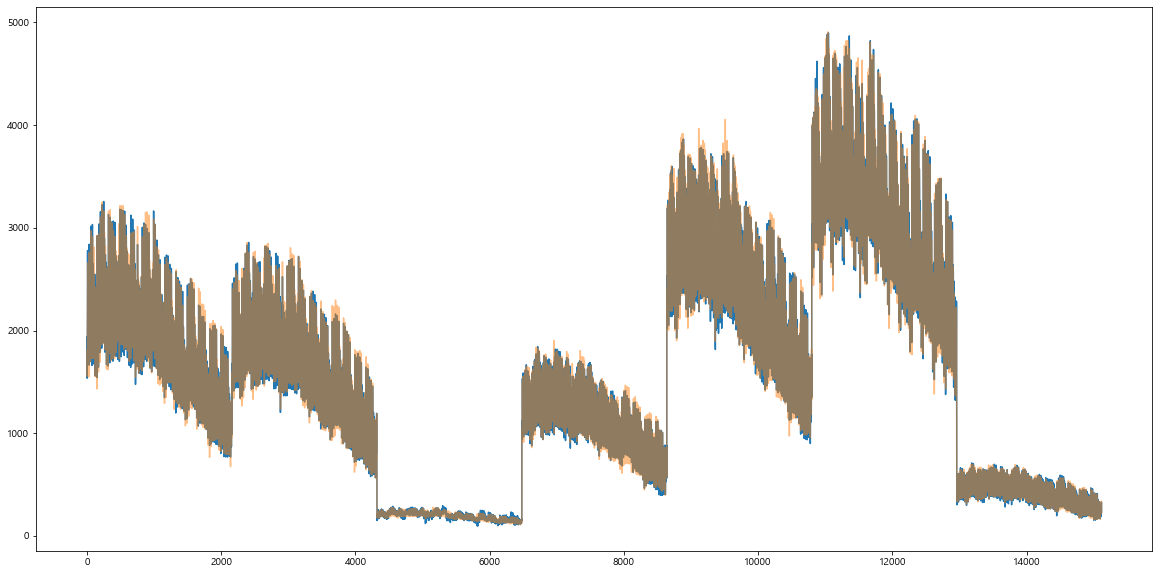

In [ ]:
plt.figure(figsize=(20,10))
pd.Series(pred).plot()
xgboost_without.plot(alpha=0.5)

# dacon baseline

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb

In [ ]:
total = pd.read_csv('data/no_outlier_data.csv', encoding='cp949')
total

,supplys,year,month,day,weekday,hour,datetime,avg_temp,mini_temp,max_temp,target
0,A,2013,1,1,1,1,2013-01-01,-3.2,-9.1,2.6,2497.129
1,A,2013,1,1,1,2,2013-01-01,-3.2,-9.1,2.6,2363.265
2,A,2013,1,1,1,3,2013-01-01,-3.2,-9.1,2.6,2258.505
3,A,2013,1,1,1,4,2013-01-01,-3.2,-9.1,2.6,2243.969
4,A,2013,1,1,1,5,2013-01-01,-3.2,-9.1,2.6,2344.105
...,...,...,...,...,...,...,...,...,...,...,...
367915,H,2018,12,31,0,20,2018-12-31,-3.2,-9.9,4.0,681.033
367916,H,2018,12,31,0,21,2018-12-31,-3.2,-9.9,4.0,669.961
367917,H,2018,12,31,0,22,2018-12-31,-3.2,-9.9,4.0,657.941
367918,H,2018,12,31,0,23,2018-12-31,-3.2,-9.9,4.0,610.953


In [ ]:
d_map = {}
for i, d in enumerate(total['supplys'].unique()):
    d_map[d] = i
total['supplys'] = total['supplys'].map(d_map)
total

,supplys,year,month,day,weekday,hour,datetime,avg_temp,mini_temp,max_temp,target
0,0,2013,1,1,1,1,2013-01-01,-3.2,-9.1,2.6,2497.129
1,0,2013,1,1,1,2,2013-01-01,-3.2,-9.1,2.6,2363.265
2,0,2013,1,1,1,3,2013-01-01,-3.2,-9.1,2.6,2258.505
3,0,2013,1,1,1,4,2013-01-01,-3.2,-9.1,2.6,2243.969
4,0,2013,1,1,1,5,2013-01-01,-3.2,-9.1,2.6,2344.105
...,...,...,...,...,...,...,...,...,...,...,...
367915,6,2018,12,31,0,20,2018-12-31,-3.2,-9.9,4.0,681.033
367916,6,2018,12,31,0,21,2018-12-31,-3.2,-9.9,4.0,669.961
367917,6,2018,12,31,0,22,2018-12-31,-3.2,-9.9,4.0,657.941
367918,6,2018,12,31,0,23,2018-12-31,-3.2,-9.9,4.0,610.953


In [ ]:
# total['연월일'] = pd.to_datetime(total['연월일'])

In [ ]:
# total['year'] = total['연월일'].dt.year
# total['month'] = total['연월일'].dt.month
# total['day'] = total['연월일'].dt.day
# total['weekday'] = total['연월일'].dt.weekday

In [ ]:
train_years = [2013,2014,2015,2016,2017]
val_years = [2018]

In [ ]:
train = total[total['year'].isin(train_years)]
val = total[total['year'].isin(val_years)]    

In [ ]:
features = ['supplys', 'month', 'day', 'weekday', 'hour']
train_x = train[features]
train_y = train['target']

val_x = val[features]
val_y = val['target']

In [ ]:
# 학습

In [ ]:
d_train = lgb.Dataset(train_x, train_y)
d_val = lgb.Dataset(val_x, val_y)

params = {
    'objective': 'regression',
    'metric':'mae',
    'seed':42
}

model = lgb.train(params, d_train, 500, d_val, verbose_eval=20, early_stopping_rounds=10)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001772 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 84
[LightGBM] [Info] Number of data points in the train set: 306600, number of used features: 5
[LightGBM] [Info] Start training from score 934.886226
Training until validation scores don't improve for 10 rounds
[20]	valid_0's l1: 242.049
[40]	valid_0's l1: 174.119
[60]	valid_0's l1: 158.315
[80]	valid_0's l1: 152.427
[100]	valid_0's l1: 150.295
[120]	valid_0's l1: 149.099
[140]	valid_0's l1: 147.911
[160]	valid_0's l1: 147.274
[180]	valid_0's l1: 146.276
Early stopping, best iteration is:
[188]	valid_0's l1: 146.018


In [ ]:
test = pd.read_csv('data/test.csv')
submission = pd.read_csv('data/sample_submission.csv')

In [ ]:
test.head()

,일자|시간|구분
0,2019-01-01 01 A
1,2019-01-01 02 A
2,2019-01-01 03 A
3,2019-01-01 04 A
4,2019-01-01 05 A


In [ ]:
test['일자'] = test['일자|시간|구분'].str.split(' ').str[0]
test['hour'] = test['일자|시간|구분'].str.split(' ').str[1].astype(int)
test['구분'] = test['일자|시간|구분'].str.split(' ').str[2]

In [ ]:
test['일자'] = pd.to_datetime(test['일자'])
test['year'] = test['일자'].dt.year
test['month'] = test['일자'].dt.month
test['day'] = test['일자'].dt.day
test['weekday'] = test['일자'].dt.weekday

In [ ]:
test['supplys'] = test['구분'].map(d_map)

In [ ]:
test_x = test[features]
test_x

,supplys,month,day,weekday,hour
0,0,1,1,1,1
1,0,1,1,1,2
2,0,1,1,1,3
3,0,1,1,1,4
4,0,1,1,1,5
...,...,...,...,...,...
15115,6,3,31,6,20
15116,6,3,31,6,21
15117,6,3,31,6,22
15118,6,3,31,6,23


In [ ]:
preds = model.predict(test_x)

In [ ]:
baseline = pd.read_csv('data/baseline.csv')['공급량']

<AxesSubplot:>

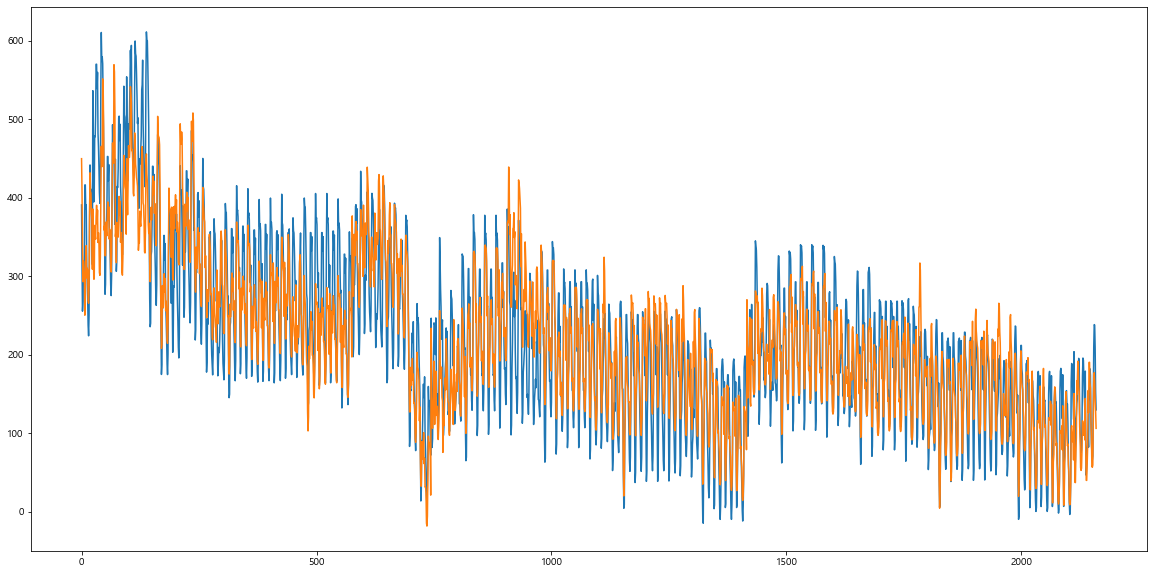

In [ ]:
#c사
idx=2
plt.figure(figsize=(20,10))
baseline[2160*idx:2160*(idx+1)].reset_index(drop=True).plot()
pd.Series(preds[2160*idx:2160*(idx+1)]).plot()

In [ ]:
preds

array([2164.27881587, 2002.53389802, 1872.10408961, ...,  370.8683194 ,
        342.41086997,  324.73547661])

In [ ]:
submission['공급량'] = preds


In [ ]:
# submission.to_csv('/data/baseline_2.csv', index=False)

In [ ]:
count = 0
for i,j in zip(submission['공급량'], baseline):
    if i == j:
        count +=1

print(count / len(baseline) * 100)

82.30820105820106


In [ ]:
#total2

In [ ]:
total2 = pd.read_csv("data/no_outlier_data.csv")

In [ ]:
d_map = {}
for i, d in enumerate(total['구분'].unique()):
    d_map[d] = i
total['구분'] = total['구분'].map(d_map)

In [ ]:
total2['연월일'] = pd.to_datetime(total['연월일'])

In [ ]:
total2['year'] = total2['연월일'].dt.year
total['month'] = total2['연월일'].dt.month
total2['day'] = total2['연월일'].dt.day
total2['weekday'] = total2['연월일'].dt.weekday

In [ ]:
train_years = [2013,2014,2015,2016,2017]
val_years = [2018]

In [ ]:
train = total2[total2['year'].isin(train_years)]
val = total2[total2['year'].isin(val_years)]    

In [ ]:
features = ['구분', 'month', 'day', 'weekday', '시간']
train_x = train[features]
train_y = train['공급량']

val_x = val[features]
val_y = val['공급량']

KeyError: "['구분', '시간'] not in index"

In [ ]:
# 학습

In [ ]:
d_train = lgb.Dataset(train_x, train_y)
d_val = lgb.Dataset(val_x, val_y)

params = {
    'objective': 'regression',
    'metric':'mae',
    'seed':42
}

model = lgb.train(params, d_train, 500, d_val, verbose_eval=20, early_stopping_rounds=10)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001136 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 84
[LightGBM] [Info] Number of data points in the train set: 306768, number of used features: 5
[LightGBM] [Info] Start training from score 934.864036
Training until validation scores don't improve for 10 rounds
[20]	valid_0's l1: 244.857
[40]	valid_0's l1: 174.855
[60]	valid_0's l1: 158.739
[80]	valid_0's l1: 153.323
[100]	valid_0's l1: 150.948
[120]	valid_0's l1: 150.463
Early stopping, best iteration is:
[112]	valid_0's l1: 150.297


In [ ]:
test = pd.read_csv('data/test.csv')
submission = pd.read_csv('data/sample_submission.csv')

In [ ]:
test.head()

,일자|시간|구분
0,2019-01-01 01 A
1,2019-01-01 02 A
2,2019-01-01 03 A
3,2019-01-01 04 A
4,2019-01-01 05 A


In [ ]:
test['일자'] = test['일자|시간|구분'].str.split(' ').str[0]
test['시간'] = test['일자|시간|구분'].str.split(' ').str[1].astype(int)
test['구분'] = test['일자|시간|구분'].str.split(' ').str[2]

In [ ]:
test['일자'] = pd.to_datetime(test['일자'])
test['year'] = test['일자'].dt.year
test['month'] = test['일자'].dt.month
test['day'] = test['일자'].dt.day
test['weekday'] = test['일자'].dt.weekday

In [ ]:
test['구분'] = test['구분'].map(d_map)

In [ ]:
test_x = test[features]


In [ ]:
preds = model.predict(test_x)